In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Reproducibility: fix random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device configuration: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
DATA_PATH = "../../kaggle_data/digit-recognizer/"
train_data = pd.read_csv(DATA_PATH+"train.csv")
test_data = pd.read_csv(DATA_PATH+'test.csv')
train_labels = train_data['label'].values
train_images = train_data.drop('label', axis=1).values
test_images = test_data.values

In [3]:
# Normalize pixel values

train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

train_images = train_images.reshape(-1, 28, 28)
test_images = test_images.reshape(-1, 28, 28)

print(f'Train images: {train_images.shape}, Train labels: {train_labels.shape}')
print(f'Test images: {test_images.shape}')

Train images: (42000, 28, 28), Train labels: (42000,)
Test images: (28000, 28, 28)


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=seed,
)
print(f'Train split: {X_train.shape}, Validation split: {X_val.shape}')

Train split: (33600, 28, 28), Validation split: (8400, 28, 28)


In [5]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        img = transforms.ToPILImage()(img)
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            return img, int(self.labels[idx])
        else:
            return img
        
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNISTDataset(X_train, y_train, transform=train_transform)
val_dataset = MNISTDataset(X_val, y_val, transform=test_transform)
test_dataset = MNISTDataset(test_images, labels=None, transform=test_transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

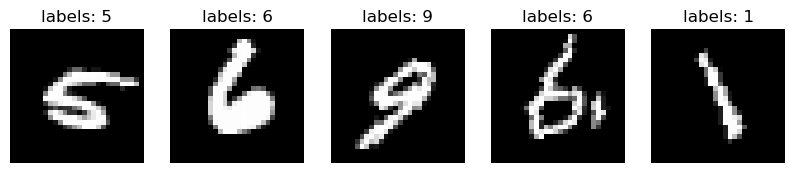

In [6]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1,5, figsize=(10,2))
for i in range(5):
    ax = axes[i]
    img = images[i].squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'labels: {labels[i].item()}')
    ax.axis('off')

plt.show()

In [7]:
class V1_3_CNN(nn.Module):
    def __init__(self):
        super(V1_3_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 3 * 3, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 10)
        )

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)

        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
model = V1_3_CNN().to(device)
print(model)

V1_3_CNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=

In [8]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch}/{num_epochs}: Train Loss = {epoch_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}')



Epoch 1/10: Train Loss = 0.7030, Val Loss = 0.5544, Val Acc = 0.9892
Epoch 2/10: Train Loss = 0.5537, Val Loss = 0.5458, Val Acc = 0.9929
Epoch 3/10: Train Loss = 0.5407, Val Loss = 0.5368, Val Acc = 0.9919
Epoch 4/10: Train Loss = 0.5327, Val Loss = 0.5254, Val Acc = 0.9940
Epoch 5/10: Train Loss = 0.5284, Val Loss = 0.5356, Val Acc = 0.9924
Epoch 6/10: Train Loss = 0.5273, Val Loss = 0.5266, Val Acc = 0.9944
Epoch 7/10: Train Loss = 0.5219, Val Loss = 0.5301, Val Acc = 0.9935
Epoch 8/10: Train Loss = 0.5209, Val Loss = 0.5205, Val Acc = 0.9955
Epoch 9/10: Train Loss = 0.5202, Val Loss = 0.5226, Val Acc = 0.9944
Epoch 10/10: Train Loss = 0.5176, Val Loss = 0.5202, Val Acc = 0.9954


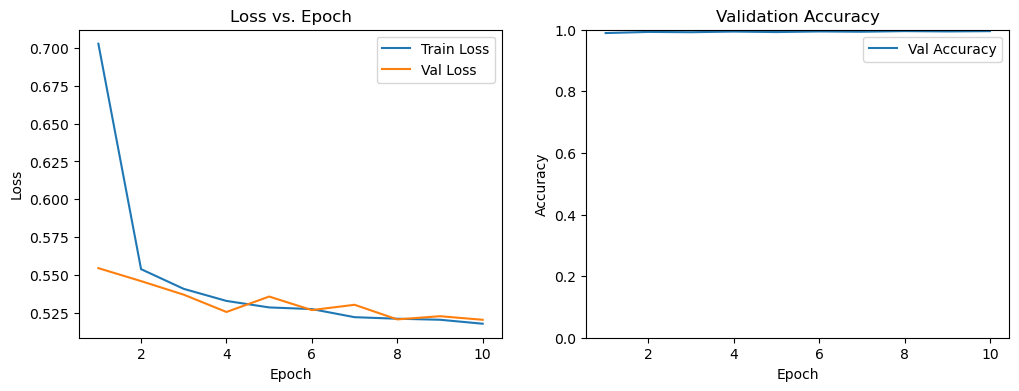

In [9]:
# Plot training and validation curves
epochs = np.arange(1, num_epochs+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.title('Loss vs. Epoch')

plt.subplot(1,2,2)
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0); plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [10]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[825   0   0   0   0   0   2   0   0   0]
 [  0 935   0   1   0   0   0   1   0   0]
 [  0   0 830   0   0   0   1   3   0   1]
 [  1   0   0 865   0   1   0   1   1   1]
 [  0   1   0   0 809   0   0   0   0   4]
 [  0   0   0   1   0 754   2   0   1   1]
 [  0   0   0   0   1   0 826   0   0   0]
 [  0   2   0   1   1   0   0 875   0   1]
 [  0   0   0   0   0   0   1   0 808   4]
 [  1   0   0   0   1   0   0   1   1 834]]


In [11]:
# Normalize confusion matrix for visualization (optional)
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)
print("Per-class accuracy:", np.diag(cm_norm))

Per-class accuracy: [0.99758162 0.99786553 0.99401198 0.99425287 0.99385749 0.99341238
 0.99879081 0.99431818 0.99384994 0.99522673]


In [12]:
model.eval()
image_ids = []
predictions = []

with torch.no_grad():
    for i, images in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        # Compute the corresponding ImageIds for this batch
        start_id = i * batch_size + 1
        for offset, pred in enumerate(preds):
            image_ids.append(start_id + offset)
            predictions.append(pred)

submission_df = pd.DataFrame({'ImageId': image_ids, 'Label': predictions})
submission_df.to_csv("submission.csv", index=False)
print(submission_df.head())

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3
